In [2]:
import praw
import pandas as pd
from datetime import datetime
import time
import logging
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
# from transformers import pipeline

In [ ]:
logging.basicConfig(filename='data_extraction.log', level=logging.INFO)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/kyle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kyle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kyle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
reddit = praw.Reddit(
    client_id='l13EfEFWXIo8ZHx6kndK8A',
    client_secret='wnQ35vd_ggELT219tsG6AKe0dUSAdg',
    user_agent='MacOS:redditScraper:v1.0 (by /u/kyle_stein)'
)

In [ ]:
subreddit_name = 'Etoro'

In [ ]:
def preprocess_text(text):
    # Remove HTML tags and special characters
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text

In [ ]:
subreddit = reddit.subreddit(subreddit_name)

posts = []
comments_data = []

try:
    # Retrieve posts with pagination
    last_post_id = None
    while True:
        # Adjust the limit as needed
        posts_batch = list(subreddit.new(limit=100, params={'after': last_post_id}))
        if not posts_batch:
            break

        for post in posts_batch:
            post_data = {
                'title': post.title,
                'score': post.score,
                'id': post.id,
                'url': post.url,
                'num_comments': post.num_comments,
                'created_utc': datetime.fromtimestamp(post.created_utc),
                'body': post.selftext,
                'username': post.author.name if post.author else '[deleted]',
                'upvote_ratio': post.upvote_ratio,
                'is_original_content': post.is_original_content,
                'flair': post.link_flair_text,
                'is_video': post.is_video,
                'domain': post.domain,
                'is_self': post.is_self,
                'is_stickied': post.stickied,
                'over_18': post.over_18,
                'total_awards_received': post.total_awards_received,
                'gilded': post.gilded,
                'edited': post.edited,
                'comment_sort': post.comment_sort,
                'permalink': f'https://www.reddit.com{post.permalink}',
                'is_media': bool(post.media),
                'media_url': post.url if post.media else None,
                'is_crosspost': post.num_crossposts > 0,
                # 'original_subreddit': post.crosspost_parent.subreddit.display_name if post.num_crossposts > 0 else None,
                'stickied': post.stickied
            }
            posts.append(post_data)

            post.comments.replace_more(limit=None)  # Retrieve all comments, including nested ones
            for comment in post.comments.list():
                comment_data = {
                    'comment_id': comment.id,
                    'post_id': post.id,
                    'parent_id': comment.parent_id,
                    'comment_body': comment.body,
                    'comment_author': comment.author.name if comment.author else '[deleted]',
                    'comment_score': comment.score,
                    'comment_created_utc': datetime.fromtimestamp(comment.created_utc),
                    'comment_gilded': comment.gilded,
                    'comment_edited': comment.edited,
                    'comment_is_submitter': comment.is_submitter,
                    'comment_stickied': comment.stickied
                }
                comments_data.append(comment_data)

        last_post_id = posts_batch[-1].fullname
        time.sleep(1)  # Add a delay to avoid hitting rate limits

    df_posts = pd.DataFrame(posts)
    df_comments = pd.DataFrame(comments_data)

    # Data validation and cleaning
    df_posts['created_utc'] = pd.to_datetime(df_posts['created_utc'])
    df_comments['comment_created_utc'] = pd.to_datetime(df_comments['comment_created_utc'])

    # Handle missing values
    df_posts.fillna('', inplace=True)
    df_comments.fillna('', inplace=True)

    # Perform text preprocessing and feature engineering
    df_posts['body'] = df_posts['body'].apply(preprocess_text)
    df_comments['comment_body'] = df_comments['comment_body'].apply(preprocess_text)

    # Save data to files
    # df_posts.to_csv('posts_data.csv', index=False)
    # df_comments.to_csv('comments_data.csv', index=False)

    logging.info("Data extraction completed successfully.")


except Exception as e:
    logging.error(f"An error occurred: {str(e)}")


In [ ]:
df_posts

,title,score,id,url,num_comments,created_utc,body,username,upvote_ratio,is_original_content,...,over_18,total_awards_received,gilded,edited,comment_sort,permalink,is_media,media_url,is_crosspost,stickied
0,"eToro is not showing live charts, have to refr...",2,1bvwhiu,https://www.reddit.com/r/Etoro/comments/1bvwhi...,2,2024-04-04 14:35:29,lot money invested sp500 basically freefall ri...,WriterJasonLaw,0.75,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/1bvwhi...,False,,False,False
1,Is it ethical to invest with etoro now?,0,1bvk905,https://www.reddit.com/r/Etoro/comments/1bvk90...,34,2024-04-04 05:59:35,given israeli company genuinely looking opinion,MrSnrub3000,0.21,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/1bvk90...,False,,False,False
2,My Short Position Closed below my Stop Loss,1,1bvbpz4,https://www.reddit.com/r/Etoro/comments/1bvbpz...,1,2024-04-03 21:19:35,x200b got short position nasdaq closed stop lo...,samuelsfx,0.60,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/1bvbpz...,False,,False,False
3,Change Account Email Address Advice,1,1busgm2,https://www.reddit.com/r/Etoro/comments/1busgm...,0,2024-04-03 08:21:50,im looking anyone changed email address etoro ...,RockHopper73,1.00,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/1busgm...,False,,False,False
4,Withdraw USD to Revolut (EU EUR Account),7,1buobjg,https://www.reddit.com/r/Etoro/comments/1buobj...,5,2024-04-03 04:30:52,hi guy x200b searching information couldnt fin...,bmbsoares,1.00,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/1buobj...,False,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,Can't buy XRP in United States,3,12a8ml3,https://www.reddit.com/r/Etoro/comments/12a8ml...,6,2023-04-02 22:52:58,deal able buy xrp whole reason joined etoro xr...,jmalty,1.00,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/12a8ml...,False,,False,False
934,Looking for a way to exit the platform,1,129fmv1,https://www.reddit.com/r/Etoro/comments/129fmv...,10,2023-04-02 04:02:07,havent done kyc verification would like sell e...,allegorycave,0.67,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/129fmv...,False,,False,False
935,eTORO usa.. IN nj,1,129f1wp,https://www.reddit.com/r/Etoro/comments/129f1w...,0,2023-04-02 03:33:19,tax identification number,Calm-Concern2,1.00,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/129f1w...,False,,False,False
936,How to deposit money to eToro money app?,2,128xzxb,https://www.reddit.com/r/Etoro/comments/128xzx...,7,2023-04-01 15:35:01,hello send money etoro money app created accou...,Yazais,0.75,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/128xzx...,False,,False,False


In [ ]:
# df_posts
df_comments

,comment_id,post_id,parent_id,comment_body,comment_author,comment_score,comment_created_utc,comment_gilded,comment_edited,comment_is_submitter,comment_stickied
0,ky2i6qy,1bvwhiu,t3_1bvwhiu,use tradingview basic free,Prestigious-County44,1,2024-04-04 15:35:31,0,False,False,False
1,kxzvno0,1bvk905,t3_1bvk905,question right answer ok drive german car holo...,marcpcd,19,2024-04-04 06:16:46,0,1712245825.0,False,False
2,kxzv2hc,1bvk905,t3_1bvk905,depending far rabbit hole go investing unethic...,majorpickle01,23,2024-04-04 06:12:12,0,False,False,False
3,kxzw52u,1bvk905,t3_1bvk905,making money market market move matter happens...,SmokeyProductions,6,2024-04-04 06:21:09,0,False,False,False
4,kxzx73j,1bvk905,t3_1bvk905,consider etoro global company founded private ...,jokulamoko,5,2024-04-04 06:30:39,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
5536,k9trozw,128xzxb,t1_k7oin7o,e toro,Sindog40,1,2023-11-18 17:57:30,0,False,False,False
5537,jej0rsk,128iu8w,t3_128iu8w,happened february bro,UristUrist,2,2023-04-01 07:10:42,0,False,False,False
5538,jejgc3f,128iu8w,t3_128iu8w,lancaster uni grew watch list,CompetitiveArcher431,2,2023-04-01 09:27:19,0,False,False,False
5539,jeke79l,128iu8w,t1_jej0rsk,correction like one february happens often foc...,AnoKamUsr,0,2023-04-01 13:25:31,0,False,True,False


In [ ]:
# df_posts.to_csv('posts_data.csv', index=False)
# df_comments.to_csv('comments_data.csv', index=False)

## Categorize

In [ ]:
# Comment count categorization
comment_count_thresholds = [0, 10, 50, 100, 500]

posts_comment_categories = {}
for i in range(len(comment_count_thresholds) - 1):
    lower = comment_count_thresholds[i]
    upper = comment_count_thresholds[i + 1]
    subset = df_posts[(df_posts['num_comments'] > lower) & (df_posts['num_comments'] <= upper)]
    posts_comment_categories[f'{lower+1} to {upper} comments'] = subset


# Upvote count categorization
score_thresholds = [0, 10, 50, 100, 500]

posts_score_categories = {}
for i in range(len(score_thresholds) - 1):
    lower = score_thresholds[i]
    upper = score_thresholds[i + 1]
    subset = df_posts[(df_posts['score'] > lower) & (df_posts['score'] <= upper)]
    posts_score_categories[f'{lower+1} to {upper} upvotes'] = subset

In [ ]:
for category, subset in posts_comment_categories.items():
    print(f"{category}: {len(subset)} posts")

for category, subset in posts_score_categories.items():
    print(f"{category}: {len(subset)} posts")

1 to 10 comments: 653 posts
11 to 50 comments: 135 posts
51 to 100 comments: 3 posts
101 to 500 comments: 3 posts
1 to 10 upvotes: 762 posts
11 to 50 upvotes: 40 posts
51 to 100 upvotes: 2 posts
101 to 500 upvotes: 0 posts


### Sentiment Analysis

In [ ]:
df_posts['sentiment'] = df_posts['body'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_comments['sentiment'] = df_comments['comment_body'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
average_post_sentiment = df_posts['sentiment'].mean()
print(f"Average sentiment of posts: {average_post_sentiment}")

average_comment_sentiment = df_comments['sentiment'].mean()
print(f"Average sentiment of comments: {average_comment_sentiment}")

Average sentiment of posts: 0.05610183928219931
Average sentiment of comments: 0.07396493851376486


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kyle/nltk_data...


True

In [ ]:
sia = SentimentIntensityAnalyzer()

df_posts['sentiment'] = df_posts['body'].apply(lambda x: sia.polarity_scores(x)['compound'])
df_comments['sentiment'] = df_comments['comment_body'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [ ]:
print(f"Average sentiment score for posts (VADER): {df_posts['sentiment'].mean()}")
print(f"Average sentiment score for comments (VADER): {df_comments['sentiment'].mean()}")

Average sentiment score for posts (VADER): 0.19372185501066097
Average sentiment score for comments (VADER): 0.15864757264031762


In [ ]:
classifier = pipeline('sentiment-analysis')

def get_sentiment(text):
    result = classifier(text)[0]
    return result['score'] if result['label'] == 'POSITIVE' else -result['score']

df_posts['sentiment'] = df_posts['body'].apply(get_sentiment)
df_comments['sentiment'] = df_comments['comment_body'].apply(get_sentiment)


In [ ]:
print(f"Average sentiment score for posts (Transformers): {df_posts['transformer_sentiment'].mean()}")
print(f"Average sentiment score for comments (Transformers): {df_comments['transformer_sentiment'].mean()}")

In [ ]:
# Plot distribution of sentiment scores for posts
plt.figure(figsize=(10, 5))
plt.hist(df_posts['sentiment'], bins=20, alpha=0.7, label='VADER Sentiment')
# Assuming transformer sentiment scores are stored
plt.hist(df_posts['transformer_sentiment'], bins=20, alpha=0.7, label='Transformer Sentiment')
plt.title('Distribution of Sentiment Scores for Posts')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Repeat similar visualization for comments


In [ ]:
print("Example posts with their sentiment scores:")
print(df_posts[['body', 'sentiment']].head())

In [ ]:
# Scatter plot to compare VADER and transformer sentiment scores
plt.figure(figsize=(10, 5))
plt.scatter(df_posts['sentiment'], df_posts['transformer_sentiment'], alpha=0.5)
plt.title('Comparison of Sentiment Scores: VADER vs. Transformers')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Transformer Sentiment Score')
plt.show()


Most common named entities in posts:
one (CARDINAL): 76 occurrences
first (ORDINAL): 38 occurrences
1 (CARDINAL): 38 occurrences
2 (CARDINAL): 37 occurrences
today (DATE): 36 occurrences
500 (CARDINAL): 22 occurrences
1000 (CARDINAL): 20 occurrences
200 (CARDINAL): 19 occurrences
two (CARDINAL): 18 occurrences
50 (CARDINAL): 16 occurrences


In [ ]:
# Compute correlation between VADER and transformer sentiment scores
correlation = df_posts['sentiment'].corr(df_posts['transformer_sentiment'])
print(f"Correlation between VADER and Transformer sentiment scores for posts: {correlation}")

### Time Series Analysis

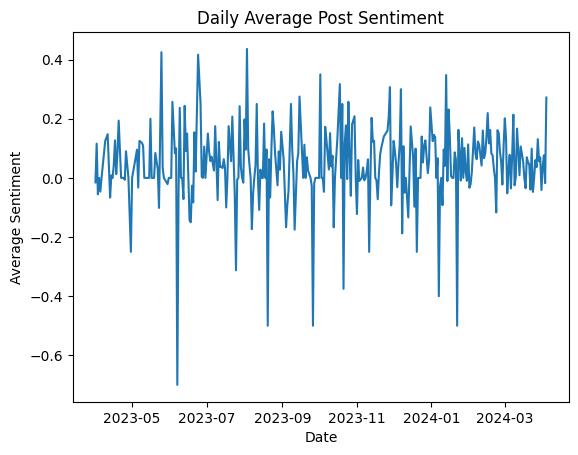

In [ ]:
# Time series analysis of average post sentiment over time
df_posts['created_date'] = df_posts['created_utc'].dt.date
daily_sentiment = df_posts.groupby('created_date')['sentiment'].mean()

daily_sentiment.plot()
plt.title('Daily Average Post Sentiment')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()

### User Analysis

In [ ]:
user_post_counts = df_posts['username'].value_counts()
user_comment_counts = df_comments['comment_author'].value_counts()

In [ ]:
print("Top users by post count:")
print(user_post_counts.head())

print("\nTop users by comment count:")
print(user_comment_counts.head())

Top users by post count:
username
CopyTradingForum    34
[deleted]           16
SandwichOk8222      11
chicanoharley        8
BetPaka              6
Name: count, dtype: int64

Top users by comment count:
comment_author
[deleted]            194
MrPopanz              85
Felsommer             77
Left_Actuary_7890     59
vincenzost            57
Name: count, dtype: int64


### Hyperlink Analysis

In [ ]:
def extract_hyperlinks(text):
    return re.findall(r'(https?://[^\s]+)', text)

df_posts['hyperlinks'] = df_posts['body'].apply(extract_hyperlinks)

In [ ]:
# total_hyperlinks = df_posts['hyperlinks'].explode().dropna().nunique()
# print(f"Total unique hyperlinks found in posts: {total_hyperlinks}")


# all_hyperlinks = df_posts['hyperlinks'].explode().dropna().tolist()
# hyperlink_counts = Counter(all_hyperlinks)

# print("Most common hyperlinks in posts:")
# for url, count in hyperlink_counts.most_common(10):
#     print(f"{url}: {count} occurrences")


# df_posts['hyperlink_count'] = df_posts['hyperlinks'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# print(df_posts['hyperlink_count'].describe())



# plt.figure(figsize=(10, 6))
# df_posts['hyperlink_count'].hist(bins=range(1, df_posts['hyperlink_count'].max() + 1))
# plt.title('Distribution of Hyperlinks per Post')
# plt.xlabel('Number of Hyperlinks')
# plt.ylabel('Number of Posts')
# plt.grid(False)
# plt.show()


count    938.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: hyperlink_count, dtype: float64


### NER

In [ ]:
nlp = spacy.load("en_core_web_sm")

df_posts['named_entities'] = df_posts['body'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

In [ ]:
# Flatten the list of entities from all posts and count occurrences
all_entities = [entity for sublist in df_posts['named_entities'] for entity in sublist]
entity_counts = Counter(all_entities)

print("Most common named entities in posts:")
for entity, count in entity_counts.most_common(10):
    print(f"{entity[0]} ({entity[1]}): {count} occurrences")

Most common named entities in posts:
one (CARDINAL): 76 occurrences
first (ORDINAL): 38 occurrences
1 (CARDINAL): 38 occurrences
2 (CARDINAL): 37 occurrences
today (DATE): 36 occurrences
500 (CARDINAL): 22 occurrences
1000 (CARDINAL): 20 occurrences
200 (CARDINAL): 19 occurrences
two (CARDINAL): 18 occurrences
50 (CARDINAL): 16 occurrences
